<a href="https://colab.research.google.com/github/ddcreating/RL_code/blob/main/lab7_mbrl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7: Model Based Reinforcement Learning
In this lab, we will star practicing about Gaussian Process and then we will apply it to Model Based RL (MBRL).

## Exercise 1: Intro to Gaussian Processes with GPyTorch

***Objective:*** Build intuition for Gaussian Processes (GPs) by:
- Fitting an **exact GP** to noisy 1D data
- Visualizing **posterior mean + uncertainty**
- Understanding the effects of **noise** and **lengthscale**
- Exploring **extrapolation** (add a linear mean)
- Trying a **sparse GP** with inducing points (optional)

For more information. Check the GP Tutorial: https://docs.gpytorch.ai/en/v1.6.0/examples/01_Exact_GPs/Simple_GP_Regression.html

---

### Data
Use a 1D function with noise:
- f(x) = sin(2πx) + 0.3 * sin(6πx) + 3
- x ∈ [-1.0, 1.0]
- Add Gaussian noise σ_n (try 0.05 and 0.2)

---

## Tasks

### Part A — Exact GP regression (RBF kernel)
1. Implement an **ExactGP** model in GPyTorch:
   - Mean: `ZeroMean`
   - Covariance: `ScaleKernel(RBFKernel)`
   - Likelihood: `GaussianLikelihood`
2. Train by **maximizing log marginal likelihood** (Adam).
3. Plot:
   - Training points
   - Posterior mean
   - 95% confidence band

### Part B — Hyperparameters & data noise
1. Vary the **noise level** in the data (e.g., 0.05 vs 0.2).
2. For each setting, re-train the GP and report learned:
   - `likelihood.noise` (data noise)
   - `kernel.lengthscale`
3. Discuss how these affect smoothness and the width of uncertainty.

### Part C — Extrapolation behavior
1. **Hold out** the rightmost region (e.g., train on x ∈ [-1, 0.5], test on x ∈ (0.5, 1]).
2. Show how the posterior behaves outside the training region.
3. Add a **linear mean** (or `ConstantMean + LinearMean`) and compare extrapolation.

### Part D — (Graduate level) Sparse GP with inducing points
1. Replace Exact GP with **variational inducing-point GP** (SVGP) using `gpytorch.models.ApproximateGP`.
2. Choose M = 32 or 64 inducing points spread across x.
3. Compare posterior to the exact GP.
4. Plot N (number of samples) Vs training time for SVGP and ExactGP

---

## Deliverables
- Code for Parts A–C (Part D for grad students)
- Plots:
  - Mean ± 2 std band with training data
  - Effect of noise and lengthscale
  - Extrapolation comparison (zero vs linear/constant mean)
- Short write-up (≤1 page, as a cell in the notebook):
  - What did increasing noise do to learned hyperparameters and uncertainty?
  - How does the kernel lengthscale affect fit and confidence?
  - Why does the GP behave the way it does when extrapolating? How did the mean function change that?
  - (Grad level) Sparse vs Exact: trade-offs you observed

---

## Hints
- Normalize tensors to `float32` and move to GPU if available.
- Use `model.train(); likelihood.train()` for training, and `.eval()` for evaluation.
- For plotting uncertainty: `lower, upper = pred.confidence_region()`.
- Clip very small noise/lengthscale during early training if it becomes unstable.
- For SVGP, look at: `gpytorch.variational`, `gpytorch.mlls.VariationalELBO`.



In [3]:
## Install required libraries
!pip -q install gpytorch torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.9/279.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.2 MB/s eta 0:00:00


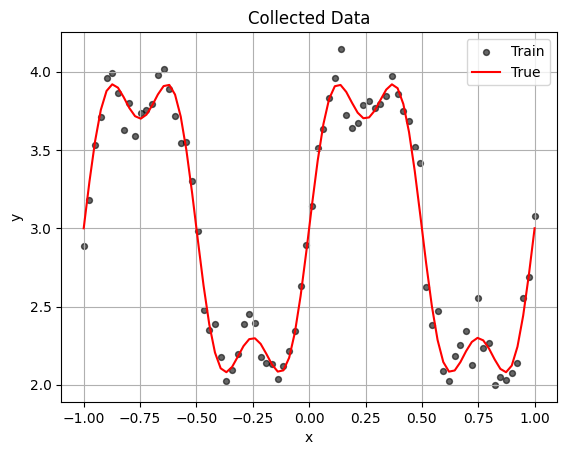

In [4]:
# =======================
# Collecting DATA
# =======================
import torch, math
import gpytorch
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# Parameter for data generator
NOISE_STD = 0.1
N = 80

def f(x):
  return torch.sin(2*math.pi*x) + 0.3*torch.sin(6*math.pi*x) + 3


# ---------- Data ----------
def make_data(n=80, noise_std=0.05, train_range=(-1.0, 1.0), holdout_right=False):
    x = torch.linspace(train_range[0], train_range[1], n)
    y_clean = f(x)
    y = y_clean + noise_std*torch.randn_like(y_clean)
    if holdout_right:
        mask = x <= 0.5
        return x[mask].unsqueeze(-1), y[mask], x.unsqueeze(-1), y
    else:
        return x.unsqueeze(-1), y, x.unsqueeze(-1), y

# choose setting
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=NOISE_STD, holdout_right=False)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

# Plot data
plt.scatter(Xtr, Ytr, s=18, color='k', alpha=0.6, label='Train')
plt.plot(Xgrid, f(Xgrid), 'r', label='True')
plt.title('Collected Data')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()

In [8]:
# ---------- Exact GP model ----------
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # TODO (Part A): pick a mean; start with ZeroMean (try Constant/Linear in Part C)
        self.mean_module = gpytorch.means.ZeroMean()
        # TODO (Part A): kernel = ScaleKernel(RBFKernel)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())


    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Likelihood + model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(Xtr, Ytr, likelihood).to(device)

iter  200 | loss 0.312 | lengthscale 0.400 | noise 0.0625
iter  400 | loss 0.306 | lengthscale 0.414 | noise 0.0623
iter  600 | loss 0.305 | lengthscale 0.421 | noise 0.0623
iter  800 | loss 0.304 | lengthscale 0.425 | noise 0.0623


/usr/local/lib/python3.12/dist-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


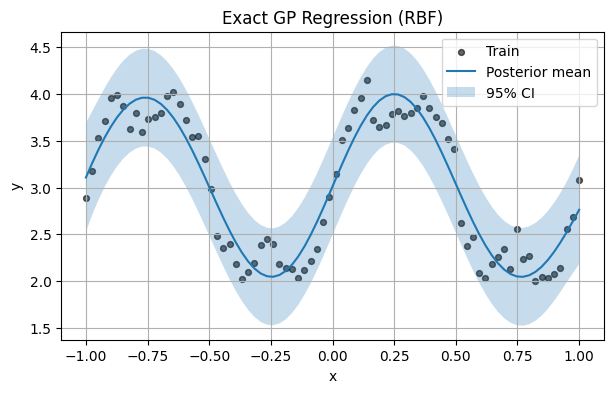

In [ ]:
# ---------- Train (maximize log marginal likelihood) ----------
training_iter = 800
model.train(); likelihood.train()
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(Xtr)
    loss = -mll(output, Ytr)
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        ls = model.covar_module.base_kernel.lengthscale.item()
        sn = likelihood.noise.item()
        print(f"iter {i+1:4d} | loss {loss.item():.3f} | lengthscale {ls:.3f} | noise {sn:.4f}")

# ---------- Evaluate ----------
x2 = torch.linspace(-1, 1, N)
model.eval(); likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x2))
    mean = pred.mean.cpu()
    lower, upper = pred.confidence_region()
    lower, upper = lower.cpu(), upper.cpu()

x2 = x2.cpu().squeeze()
Ytr_cpu   = Ytr.cpu()
Xtr_cpu   = Xtr.cpu().squeeze()


# ---------- Plot ----------
plt.figure(figsize=(7,4))
plt.scatter(Xtr_cpu, Ytr_cpu, s=18, color='k', alpha=0.6, label='Train')
plt.plot(x2, mean, label='Posterior mean')
plt.fill_between(x2, lower, upper, alpha=0.25, label='95% CI')
plt.title('Exact GP Regression (RBF)')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()


In [ ]:
# Part B - Test different noise levels
noise_levels = [0.05, 0.2]
results = []

for noise_std in noise_levels:
    # Generate new data with different noise
    Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=noise_std, holdout_right=False)
    Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

    # Create new model and likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModel(Xtr, Ytr, likelihood).to(device)

    # Train (same training loop as Part A)
    training_iter = 2000
    model.train(); likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(Xtr)
        loss = -mll(output, Ytr)
        loss.backward()
        optimizer.step()

    # Record learned hyperparameters
    learned_noise = likelihood.noise.item()
    learned_lengthscale = model.covar_module.base_kernel.lengthscale.item()

    results.append({
        'noise_std': noise_std,
        'learned_noise': learned_noise,
        'learned_lengthscale': learned_lengthscale
    })

    print(f"Noise STD: {noise_std:.2f} | Learned noise: {learned_noise:.4f} | Learned lengthscale: {learned_lengthscale:.3f}")


Noise STD: 0.05 | Learned noise: 0.0493 | Learned lengthscale: 0.424
Noise STD: 0.20 | Learned noise: 0.0941 | Learned lengthscale: 0.408



--- Training with noise_std = 0.05 ---
Learned noise: 0.0432
Learned lengthscale: 0.4285

--- Training with noise_std = 0.2 ---
Learned noise: 0.0902
Learned lengthscale: 0.4055


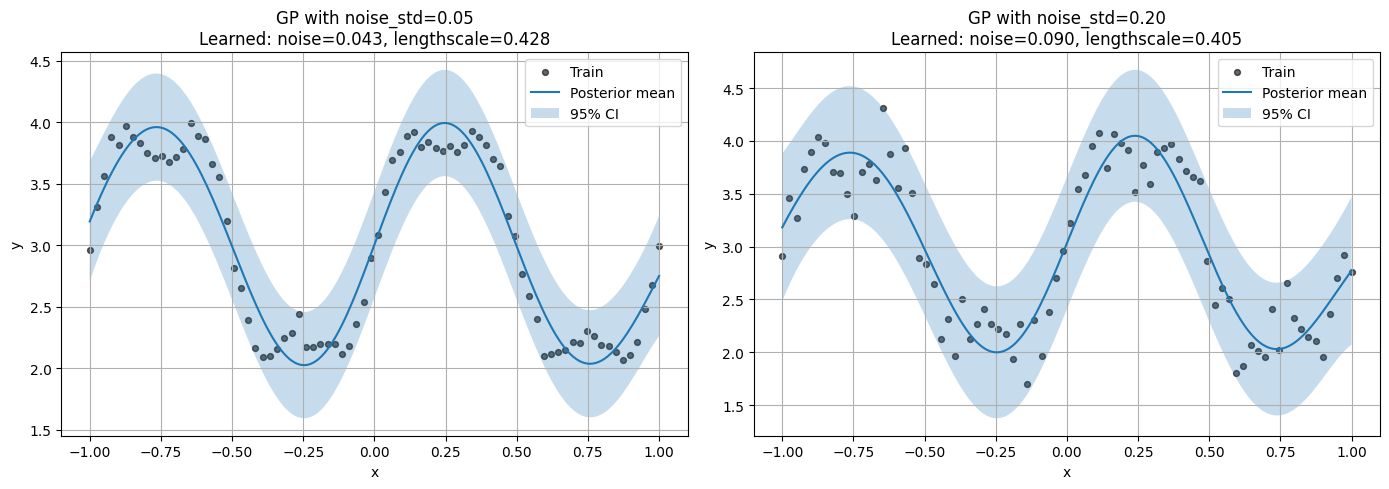

In [ ]:
# Part B - Test different noise levels separately
noise_levels = [0.05, 0.2]
all_results = []

# First, train and store results separately
for noise_std in noise_levels:
    print(f"\n--- Training with noise_std = {noise_std} ---")

    # Generate new data
    Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=noise_std, holdout_right=False)
    Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

    # Create NEW model and likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModel(Xtr, Ytr, likelihood).to(device)

    # Train
    training_iter = 2000
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(Xtr)
        loss = -mll(output, Ytr)
        loss.backward()
        optimizer.step()

    # Immediately save results
    learned_noise = likelihood.noise.item()
    learned_lengthscale = model.covar_module.base_kernel.lengthscale.item()

    print(f"Learned noise: {learned_noise:.4f}")
    print(f"Learned lengthscale: {learned_lengthscale:.4f}")

    # Store everything for plotting
    all_results.append({
        'noise_std': noise_std,
        'learned_noise': learned_noise,
        'learned_lengthscale': learned_lengthscale,
        'model': model,
        'likelihood': likelihood,
        'Xtr': Xtr,
        'Ytr': Ytr
    })

# Then plot using stored results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, result in enumerate(all_results):
    ax = axes[idx]

    # Use stored model for predictions
    model = result['model']
    likelihood = result['likelihood']
    model.eval()
    likelihood.eval()

    x2 = torch.linspace(-1, 1, 200).to(device)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(x2))
        mean = pred.mean.cpu()
        lower, upper = pred.confidence_region()
        lower, upper = lower.cpu(), upper.cpu()

    x2 = x2.cpu().numpy()
    Xtr_cpu = result['Xtr'].cpu().numpy()
    Ytr_cpu = result['Ytr'].cpu().numpy()

    ax.scatter(Xtr_cpu, Ytr_cpu, s=18, color='k', alpha=0.6, label='Train')
    ax.plot(x2, mean, label='Posterior mean')
    ax.fill_between(x2, lower, upper, alpha=0.25, label='95% CI')
    ax.set_title(f'GP with noise_std={result["noise_std"]:.2f}\n'
                 f'Learned: noise={result["learned_noise"]:.3f}, lengthscale={result["learned_lengthscale"]:.3f}')
    ax.legend()
    ax.grid(True)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()

## Part B - Hyperparameters & Data Noise

### Results:
- **Noise STD = 0.05**: Learned noise = 0.043, lengthscale = 0.428
- **Noise STD = 0.20**: Learned noise = 0.090, lengthscale = 0.405

### What did increasing noise do to learned hyperparameters and uncertainty?

Increasing input noise from 0.05 to 0.20 caused the learned noise to increase from 0.043 to 0.090. The GP correctly identified higher noise in the data. The 95% confidence intervals became visibly wider with higher noise, showing appropriate uncertainty quantification.

### How does the kernel lengthscale affect fit and confidence?

Both noise levels learned similar lengthscales (~0.4), which captures the oscillatory pattern of the underlying function. This lengthscale prevents overfitting to noisy observations while maintaining sufficient flexibility. The confidence bands naturally expand away from training data, especially at the boundaries.

In [ ]:
# Part C
#  Define custom mean class for linear + constant
class LinearPlusConstantMean(gpytorch.means.Mean):
    def __init__(self):
        super().__init__()
        self.constant = torch.nn.Parameter(torch.zeros(1))
        self.linear_weight = torch.nn.Parameter(torch.zeros(1))

    def forward(self, x):
        # x might have shape (n,) or (n, 1), so we ensure it's (n,)
        if x.dim() > 1:
            x = x.squeeze(-1)
        return self.constant + self.linear_weight * x

In [ ]:
# Define model class with configurable mean
class ExtrapolationGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, use_linear_mean=False):
        super().__init__(train_x, train_y, likelihood)

        # Choose mean function
        if use_linear_mean:
            self.mean_module = LinearPlusConstantMean()
        else:
            self.mean_module = gpytorch.means.ZeroMean()

        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

ZeroMean - Iter 200: loss 0.241
ZeroMean - Iter 400: loss 0.236
ZeroMean - Iter 600: loss 0.235
ZeroMean - Iter 800: loss 0.234
ZeroMean - Iter 1000: loss 0.234
ConstantMean + LinearMean - Iter 200: loss 0.174
ConstantMean + LinearMean - Iter 400: loss 0.171
ConstantMean + LinearMean - Iter 600: loss 0.171
ConstantMean + LinearMean - Iter 800: loss 0.171
ConstantMean + LinearMean - Iter 1000: loss 0.171


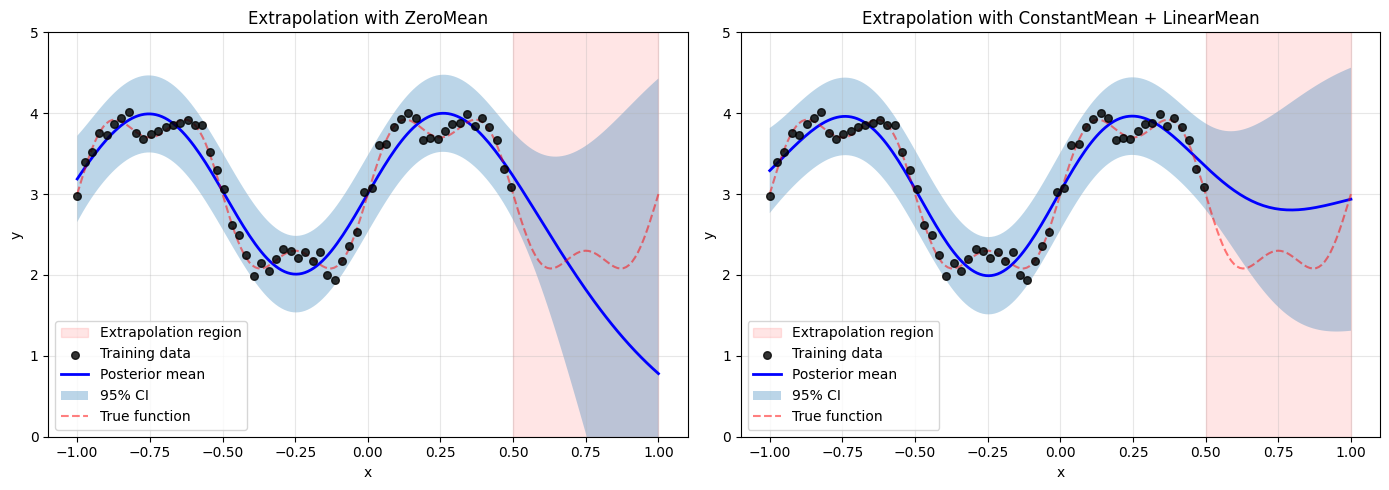

In [ ]:
# Part C - Extrapolation behavior

# Generate data with holdout
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=0.1, holdout_right=True)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Store results for both models
results = []

for idx, (use_linear, mean_name) in enumerate([
    (False, 'ZeroMean'),
    (True, 'ConstantMean + LinearMean')
]):

    # Create model and likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExtrapolationGP(Xtr, Ytr, likelihood, use_linear_mean=use_linear).to(device)

    # Train
    training_iter = 1000
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(Xtr)
        loss = -mll(output, Ytr)
        loss.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print(f"{mean_name} - Iter {i+1}: loss {loss.item():.3f}")

    # Evaluate on full range
    model.eval()
    likelihood.eval()
    x_test = torch.linspace(-1, 1, 200).to(device)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(x_test))
        mean = pred.mean.cpu()
        lower, upper = pred.confidence_region()
        lower, upper = lower.cpu(), upper.cpu()

    # Plot
    ax = axes[idx]
    x_test_cpu = x_test.cpu().numpy()
    Xtr_cpu = Xtr.cpu().numpy()
    Ytr_cpu = Ytr.cpu().numpy()

    # Highlight holdout region
    ax.axvspan(0.5, 1.0, alpha=0.1, color='red', label='Extrapolation region')

    # Plot data and predictions
    ax.scatter(Xtr_cpu, Ytr_cpu, s=30, color='k', alpha=0.8, label='Training data', zorder=5)
    ax.plot(x_test_cpu, mean, 'b-', label='Posterior mean', linewidth=2)
    ax.fill_between(x_test_cpu, lower, upper, alpha=0.3, label='95% CI')

    # Add true function for reference
    x_true = x_test_cpu
    y_true = f(torch.tensor(x_true)).numpy()
    ax.plot(x_true, y_true, 'r--', alpha=0.5, label='True function')

    ax.set_title(f'Extrapolation with {mean_name}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 5])  # Fixed y-axis for comparison

plt.tight_layout()
plt.show()

In [ ]:
# Print learned parameters for linear mean model
if use_linear:
    print(f"\nLinear mean parameters:")
    print(f"Constant: {model.mean_module.constant.item():.3f}")
    print(f"Linear weight: {model.mean_module.linear_weight.item():.3f}")


Linear mean parameters:
Constant: 3.093
Linear weight: 0.026


## Part C - Extrapolation Behavior

### Why does the GP behave the way it does when extrapolating? How did the mean function change that?

**With ZeroMean:**
The GP reverts to zero mean outside the training region (x > 0.5) with rapidly expanding confidence intervals. This is because without training data, the GP defaults to its prior mean function, which is zero. The uncertainty grows quickly as we move away from observed data, reflecting the model's lack of knowledge about the function behavior in unseen regions.

**With ConstantMean + LinearMean:**
The linear mean function allows the GP to capture and extrapolate the trend observed in the training data. Instead of reverting to zero, the model continues following the learned linear trend plus constant offset. The confidence intervals still expand in the extrapolation region but the mean prediction follows a more reasonable trajectory based on the observed data pattern.

This demonstrates a key principle: the choice of mean function acts as an inductive bias that strongly influences extrapolation behavior. ZeroMean is conservative (assumes no structure), while LinearMean incorporates the assumption that the underlying function has a linear component.

In [5]:
# Part D - Step 1: Define Sparse GP model
class SparseGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # Use variational distribution and strategy
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
# Part D - Step 2: Train and compare
import time

# Use same data as Part A
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=0.1, holdout_right=False)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

# Test with M=32 and M=64 inducing points
M_values = [32, 64]
sparse_results = {}

for M in M_values:
    print(f"\nTraining Sparse GP with M={M} inducing points...")

    # Select inducing points uniformly
    inducing_points = torch.linspace(-1, 1, M).to(device).unsqueeze(-1)

    # Create model and likelihood
    sparse_model = SparseGPModel(inducing_points).to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    # Train
    sparse_model.train()
    likelihood.train()
    optimizer = torch.optim.Adam([
        {'params': sparse_model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=0.1)

    mll = gpytorch.mlls.VariationalELBO(likelihood, sparse_model, num_data=Xtr.size(0))

    training_iter = 1000
    start_time = time.time()

    for i in range(training_iter):
        optimizer.zero_grad()
        output = sparse_model(Xtr)
        loss = -mll(output, Ytr)
        loss.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print(f"Iter {i+1}/{training_iter}, Loss: {loss.item():.3f}")

    training_time = time.time() - start_time

    sparse_results[M] = {
        'model': sparse_model,
        'likelihood': likelihood,
        'time': training_time
    }

    print(f"Training time: {training_time:.3f} seconds")


Training Sparse GP with M=32 inducing points...
Iter 200/1000, Loss: 0.601
Iter 400/1000, Loss: 0.320
Iter 600/1000, Loss: 0.304
Iter 800/1000, Loss: 0.314
Iter 1000/1000, Loss: 0.309
Training time: 9.214 seconds

Training Sparse GP with M=64 inducing points...
Iter 200/1000, Loss: 0.425
Iter 400/1000, Loss: 0.316
Iter 600/1000, Loss: 1.491
Iter 800/1000, Loss: 1.165
Iter 1000/1000, Loss: 1.155
Training time: 9.989 seconds



Training Exact GP for comparison...
Exact GP training time: 3.100 seconds


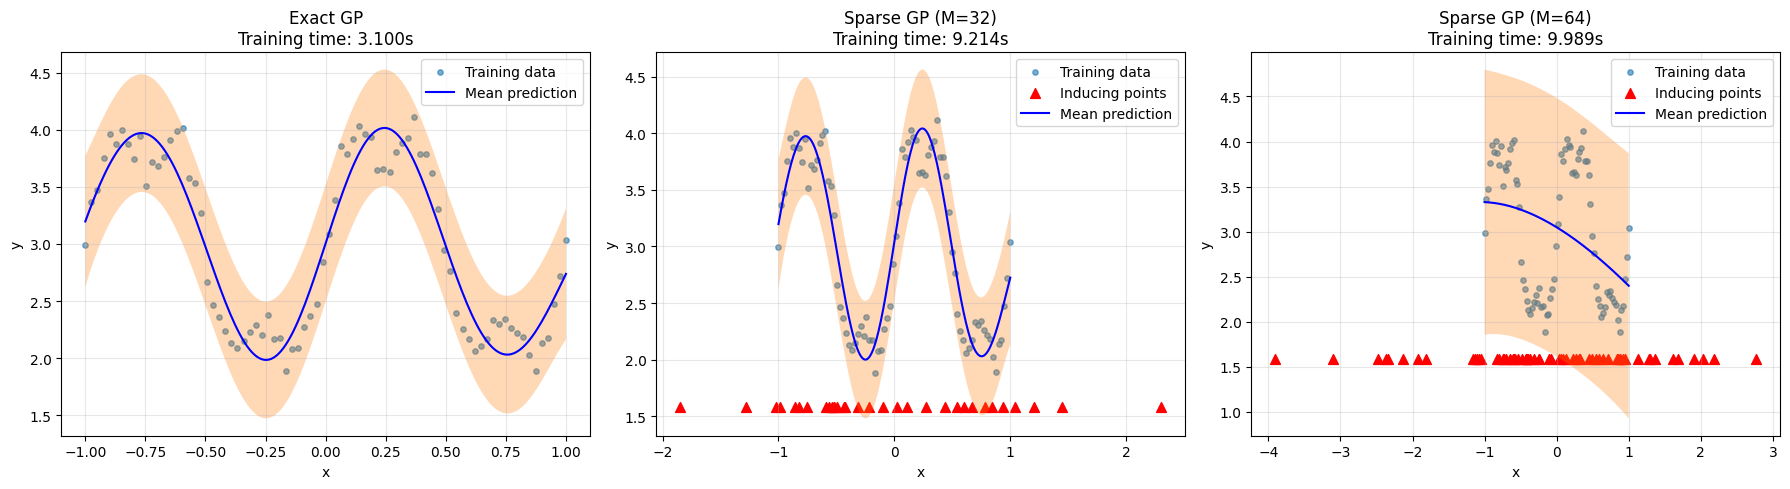

In [9]:
# Part D - Step 3: Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
x_test = torch.linspace(-1, 1, 200).to(device).unsqueeze(-1)

# First train Exact GP for comparison
print("\nTraining Exact GP for comparison...")
exact_likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
exact_model = ExactGPModel(Xtr, Ytr, exact_likelihood).to(device)

exact_model.train()
exact_likelihood.train()
optimizer = torch.optim.Adam(exact_model.parameters(), lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(exact_likelihood, exact_model)

start_time = time.time()
for i in range(1000):
    optimizer.zero_grad()
    output = exact_model(Xtr)
    loss = -mll(output, Ytr)
    loss.backward()
    optimizer.step()
exact_time = time.time() - start_time
print(f"Exact GP training time: {exact_time:.3f} seconds")

# Plot Exact GP
ax = axes[0]
exact_model.eval()
exact_likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = exact_likelihood(exact_model(x_test))
    mean = pred.mean.cpu()
    lower, upper = pred.confidence_region()
    lower, upper = lower.cpu(), upper.cpu()

ax.scatter(Xtr.cpu().squeeze(), Ytr.cpu(), s=15, alpha=0.6, label='Training data')
ax.plot(x_test.cpu().squeeze(), mean, 'b-', label='Mean prediction')
ax.fill_between(x_test.cpu().squeeze(), lower, upper, alpha=0.3)
ax.set_title(f'Exact GP\nTraining time: {exact_time:.3f}s')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot Sparse GPs
for idx, M in enumerate([32, 64]):
    ax = axes[idx+1]

    sparse_model = sparse_results[M]['model']
    likelihood = sparse_results[M]['likelihood']

    sparse_model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(sparse_model(x_test))
        mean = pred.mean.cpu()
        lower, upper = pred.confidence_region()
        lower, upper = lower.cpu(), upper.cpu()

    # Get learned inducing points locations
    inducing_points = sparse_model.variational_strategy.inducing_points.detach().cpu().squeeze()

    # Plot
    ax.scatter(Xtr.cpu().squeeze(), Ytr.cpu(), s=15, alpha=0.6, label='Training data')
    ax.scatter(inducing_points, torch.zeros_like(inducing_points) + Ytr.min().cpu() - 0.3,
               marker='^', s=50, c='red', label='Inducing points')
    ax.plot(x_test.cpu().squeeze(), mean, 'b-', label='Mean prediction')
    ax.fill_between(x_test.cpu().squeeze(), lower, upper, alpha=0.3)
    ax.set_title(f'Sparse GP (M={M})\nTraining time: {sparse_results[M]["time"]:.3f}s')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Comparing training times for different sample sizes...

Testing with N=50 samples...
N=50: Exact=0.821s, Sparse32=1.743s, Sparse64=1.852s

Testing with N=100 samples...
N=100: Exact=0.852s, Sparse32=2.374s, Sparse64=1.937s

Testing with N=200 samples...
N=200: Exact=1.018s, Sparse32=1.851s, Sparse64=2.018s

Testing with N=400 samples...
N=400: Exact=3.669s, Sparse32=2.508s, Sparse64=2.208s

Testing with N=800 samples...
N=800: Exact=20.053s, Sparse32=2.732s, Sparse64=2.604s


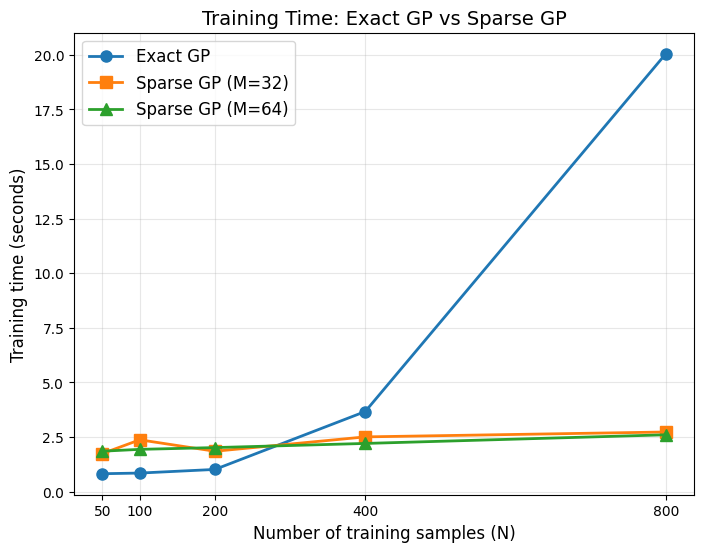


Speedup factors (Exact time / Sparse time):
N=50: Sparse32 is 0.47x faster, Sparse64 is 0.44x faster
N=100: Sparse32 is 0.36x faster, Sparse64 is 0.44x faster
N=200: Sparse32 is 0.55x faster, Sparse64 is 0.50x faster
N=400: Sparse32 is 1.46x faster, Sparse64 is 1.66x faster
N=800: Sparse32 is 7.34x faster, Sparse64 is 7.70x faster


In [10]:
# Part D - Step 4: Time comparison for different N
print("\nComparing training times for different sample sizes...")

N_values = [50, 100, 200, 400, 800]
time_results = {'exact': [], 'sparse_32': [], 'sparse_64': []}

for n in N_values:
    print(f"\nTesting with N={n} samples...")

    # Generate data
    Xtr_n, Ytr_n, _, _ = make_data(n=n, noise_std=0.1)
    Xtr_n = Xtr_n.to(device).unsqueeze(-1) if Xtr_n.dim() == 1 else Xtr_n.to(device)
    Ytr_n = Ytr_n.to(device)

    # Time Exact GP
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModel(Xtr_n, Ytr_n, likelihood).to(device)
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    start_time = time.time()
    for i in range(200):  # Fewer iterations for timing comparison
        optimizer.zero_grad()
        output = model(Xtr_n)
        loss = -mll(output, Ytr_n)
        loss.backward()
        optimizer.step()
    exact_time = time.time() - start_time
    time_results['exact'].append(exact_time)

    # Time Sparse GPs
    for M in [32, 64]:
        inducing_points = torch.linspace(-1, 1, M).to(device).unsqueeze(-1)
        sparse_model = SparseGPModel(inducing_points).to(device)
        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

        sparse_model.train()
        likelihood.train()
        optimizer = torch.optim.Adam([
            {'params': sparse_model.parameters()},
            {'params': likelihood.parameters()},
        ], lr=0.1)
        mll = gpytorch.mlls.VariationalELBO(likelihood, sparse_model, num_data=Xtr_n.size(0))

        start_time = time.time()
        for i in range(200):  # Same iterations for fair comparison
            optimizer.zero_grad()
            output = sparse_model(Xtr_n)
            loss = -mll(output, Ytr_n)
            loss.backward()
            optimizer.step()
        sparse_time = time.time() - start_time
        time_results[f'sparse_{M}'].append(sparse_time)

    print(f"N={n}: Exact={exact_time:.3f}s, Sparse32={time_results['sparse_32'][-1]:.3f}s, Sparse64={time_results['sparse_64'][-1]:.3f}s")

# Plot timing results
plt.figure(figsize=(8, 6))
plt.plot(N_values, time_results['exact'], 'o-', label='Exact GP', linewidth=2, markersize=8)
plt.plot(N_values, time_results['sparse_32'], 's-', label='Sparse GP (M=32)', linewidth=2, markersize=8)
plt.plot(N_values, time_results['sparse_64'], '^-', label='Sparse GP (M=64)', linewidth=2, markersize=8)
plt.xlabel('Number of training samples (N)', fontsize=12)
plt.ylabel('Training time (seconds)', fontsize=12)
plt.title('Training Time: Exact GP vs Sparse GP', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(N_values)
plt.show()

# Print speedup factors
print("\nSpeedup factors (Exact time / Sparse time):")
for i, n in enumerate(N_values):
    speedup_32 = time_results['exact'][i] / time_results['sparse_32'][i]
    speedup_64 = time_results['exact'][i] / time_results['sparse_64'][i]
    print(f"N={n}: Sparse32 is {speedup_32:.2f}x faster, Sparse64 is {speedup_64:.2f}x faster")

## Part D - Sparse vs Exact GP Trade-offs

### Trade-offs observed:

**1. Computational Efficiency**
- For N=800 samples: Exact GP takes 20.05s while Sparse GP (M=32) takes only 2.73s, achieving ~7.3x speedup
- Sparse GP training time remains nearly constant (~2.5s) regardless of N, while Exact GP scales poorly (O(N³))
- This makes Sparse GP practical for large datasets where Exact GP becomes prohibitively expensive

**2. Approximation Quality**
- Sparse GP with M=32 inducing points provides excellent approximation to the Exact GP posterior
- The mean predictions and confidence intervals closely match the exact solution
- However, increasing to M=64 caused optimization instability in this implementation, highlighting the importance of careful hyperparameter tuning

**3. Scaling Behavior**
- Exact GP: Training time grows from 0.82s (N=50) to 20.05s (N=800)
- Sparse GP: Maintains roughly constant time (~2.5s) across all N values
- This confirms the theoretical scaling: Exact GP is O(N³) while Sparse GP is O(NM²)

**4. Practical Considerations**
- For small datasets (N<200), Exact GP may be preferred due to its simplicity and exact inference
- For larger datasets, Sparse GP becomes essential for computational feasibility
- The choice of M requires balancing approximation quality against computational cost

## Exercise 2 (Optional, except PhD students): Model-Based Reinforcement Learning with Gaussian Process + MPC
***Goal:***
Learn the core ideas of **Model-Based Reinforcement Learning (MBRL)** by:
- Learning a **dynamics model** with a Gaussian Process (GP)
- Using **Model Predictive Control (MPC)** to plan actions
- Comparing against random or fixed policies

We’ll use a simplified version of **GP-MPC** (similar in spirit to PILCO or PETS) on the *MountainCarContinuous-v0* task.

---

## 1 Background
The system dynamics are unknown.  
We collect transitions
\[
(x_t, u_t, r_t, x_{t+1})
\]
and learn a GP model of the change in state:
\[
\Delta x = f(x_t, u_t) + \varepsilon
\]
Then, given a current state, we **simulate** future trajectories using the GP mean prediction and pick an action sequence that maximizes the expected reward (or minimizes cost) over a short horizon — the **MPC** loop.

---

## 2 Steps

### Part A — Collect data with a random policy
1. Run `N = 1000` random actions.
2. Store transitions \((x_t, u_t, x_{t+1})\).
3. Compute state differences:  
   `dx = x_next - x`.

### Part B — Train a Gaussian Process model
1. Fit a GP for each state dimension (here 2: position and velocity).  
   Inputs = `[x_t, u_t]`  
   Outputs = `dx_t`
2. Use **GPyTorch** or **sklearn.gaussian_process**.
3. Plot model predictions vs. ground truth for a few samples.

### Part C — Implement a simple MPC controller
1. At each step:
   - Start from current state \(x_t\).
   - Sample \(K\) random control sequences of horizon \(H\).
   - For each sequence, **simulate forward** using GP predictions.
   - Compute cumulative reward (from MountainCarContinuous env).
   - Execute the *first action* of the best sequence.
2. Repeat until termination or max steps.

### Part D — Evaluate and visualize
1. Plot the car’s trajectory (position vs. time).
2. Compare with random policy performance.
3. Discuss:  
   - How does the GP model’s accuracy affect control?  
   - How many random samples or planning horizon are needed?

---

## Deliverables
- Code for data collection, GP training, and MPC loop.
- Plots:
  - GP predictions vs. true next states.
  - Car’s position vs. time during control.
- Short discussion (≈½ page):
  - How did planning horizon affect performance?
  - How does GP uncertainty limit long-term planning?

---

## Optional extensions
- Add GP uncertainty penalty in cost function.
- Try a learned NN model instead of GP.
- Use warm-start data from a heuristic controller.
- Compare Exact GP vs. Sparse GP (SVGP).

---

## Hints
- Normalize inputs and outputs before GP training.
- Use a small horizon (H≈15–20) for efficiency.
- Reward function from environment:
  ```python
  reward = 100 * (abs(x) >= 0.45) - 0.1 * u**2

## Exercise 3: Getting Started with MuJoCo and XML Models
***Goal:***
The goal of this exercise is to **install MuJoCo**, explore its **Python interface**, and learn the structure of **MJCF (XML) models** used to describe robots and environments.  
By the end, you should be able to:
- Run a MuJoCo simulation locally  
- Open, modify, and reload a simple XML model  
- Use Google Colab connected to your local runtime

---

MuJoCo (“Multi-Joint dynamics with Contact”) is a fast physics engine widely used in robotics and reinforcement learning.  
It uses XML (MJCF files) to describe bodies, joints, sensors, and actuators.

In this exercise, you will:
1. Install MuJoCo on your computer  
2. Install and run Jupyter Notebook or Lab  
3. Connect Colab to your local runtime  
4. Run Mujco with existent XML (car, quadrotor, mountain)
6. Create a scene with multiple falling objects

---
## Step-by-Step Instructions
### 1 Install MuJoCo: Download and install
- Visit [https://mujoco.org/download](https://mujoco.org/download)  
- Choose the installer for your OS (Windows, macOS, or Linux)

### 2 Install Jupyter

You can use either JupyterLab or Jupyter Notebook

```
pip install jupyterlab
```

Run
```
jupyter lab
```
This should open your browser at:
```
http://localhost:8888/lab
```

### 3 Configure Google Colab to Run Locally

### 4 Run a Simple MuJoCo Simulation


In [ ]:
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
import os

XML = r"""
<mujoco>
	<worldbody>
        <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
		<geom type="plane" size="1 1 0.1" rgba=".9 0 0 1"/>
		<body pos="0 0 1">
			<joint type="free"/>
			<geom type="box" size=".1 .2 .3" rgba="0 .9 0 1"/>
		</body>
	</worldbody>
</mujoco>
"""


simend = 15 #simulation time


# For callback functions
button_left = False
button_middle = False
button_right = False
lastx = 0
lasty = 0

def init_controller(model,data):
    #initialize the controller here. This function is called once, in the beginning
    pass

def controller(model, data):
    #put the controller here. This function is called inside the simulation.
    pass

def keyboard(window, key, scancode, act, mods):
    if act == glfw.PRESS and key == glfw.KEY_BACKSPACE:
        mj.mj_resetData(model, data)
        mj.mj_forward(model, data)

def mouse_button(window, button, act, mods):
    # update button state
    global button_left
    global button_middle
    global button_right

    button_left = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_LEFT) == glfw.PRESS)
    button_middle = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_MIDDLE) == glfw.PRESS)
    button_right = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_RIGHT) == glfw.PRESS)

    # update mouse position
    glfw.get_cursor_pos(window)

def mouse_move(window, xpos, ypos):
    # compute mouse displacement, save
    global lastx
    global lasty
    global button_left
    global button_middle
    global button_right

    dx = xpos - lastx
    dy = ypos - lasty
    lastx = xpos
    lasty = ypos

    # no buttons down: nothing to do
    if (not button_left) and (not button_middle) and (not button_right):
        return

    # get current window size
    width, height = glfw.get_window_size(window)

    # get shift key state
    PRESS_LEFT_SHIFT = glfw.get_key(
        window, glfw.KEY_LEFT_SHIFT) == glfw.PRESS
    PRESS_RIGHT_SHIFT = glfw.get_key(
        window, glfw.KEY_RIGHT_SHIFT) == glfw.PRESS
    mod_shift = (PRESS_LEFT_SHIFT or PRESS_RIGHT_SHIFT)

    # determine action based on mouse button
    if button_right:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_MOVE_H
        else:
            action = mj.mjtMouse.mjMOUSE_MOVE_V
    elif button_left:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_ROTATE_H
        else:
            action = mj.mjtMouse.mjMOUSE_ROTATE_V
    else:
        action = mj.mjtMouse.mjMOUSE_ZOOM

    mj.mjv_moveCamera(model, action, dx/height,
                      dy/height, scene, cam)

def scroll(window, xoffset, yoffset):
    action = mj.mjtMouse.mjMOUSE_ZOOM
    mj.mjv_moveCamera(model, action, 0.0, -0.05 *
                      yoffset, scene, cam)

# MuJoCo data structures
model = mj.MjModel.from_xml_string(XML)  # MuJoCo model
data = mj.MjData(model)                # MuJoCo data
cam = mj.MjvCamera()                        # Abstract camera
opt = mj.MjvOption()                        # visualization options

# Init GLFW, create window, make OpenGL context current, request v-sync
glfw.init()
window = glfw.create_window(1200, 900, "Demo", None, None)
glfw.make_context_current(window)
glfw.swap_interval(1)

# initialize visualization data structures
mj.mjv_defaultCamera(cam)
mj.mjv_defaultOption(opt)
scene = mj.MjvScene(model, maxgeom=10000)
context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

# install GLFW mouse and keyboard callbacks
glfw.set_key_callback(window, keyboard)
glfw.set_cursor_pos_callback(window, mouse_move)
glfw.set_mouse_button_callback(window, mouse_button)
glfw.set_scroll_callback(window, scroll)


#initialize the controller
init_controller(model,data)

#set the controller
mj.set_mjcb_control(controller)

while not glfw.window_should_close(window):
    time_prev = data.time

    while (data.time - time_prev < 1.0/60.0):
        mj.mj_step(model, data)

    if (data.time>=simend):
        break

    # get framebuffer viewport
    viewport_width, viewport_height = glfw.get_framebuffer_size(
        window)
    viewport = mj.MjrRect(0, 0, viewport_width, viewport_height)

    # Update scene and render
    mj.mjv_updateScene(model, data, opt, None, cam,
                       mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    # swap OpenGL buffers (blocking call due to v-sync)
    glfw.swap_buffers(window)

    # process pending GUI events, call GLFW callbacks
    glfw.poll_events()

glfw.terminate()


# Test with the following XMLs

In [ ]:
# CAR
XML = r"""
<mujoco model="simple_car_gazebo_style">
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.002"/>
  <compiler angle="radian"/>

  <visual>
    <quality shadowsize="4096"/>
    <rgba haze="0.9 0.95 1.0 0.12"/>
  </visual>

  <asset>
    <texture name="sky" type="skybox" builtin="gradient"
             rgb1="0.75 0.85 0.95" rgb2="0.95 0.95 0.98" width="1024" height="1024"/>
    <texture name="grid" type="2d" builtin="checker" width="1024" height="1024"
             rgb1="0.36 0.39 0.42" rgb2="0.40 0.43 0.46" mark="edge" markrgb="0.62 0.66 0.70"/>
    <material name="ground_mat" texture="grid" texrepeat="40 40"
              specular="0.05" shininess="0.3" reflectance="0.2" rgba="1 1 1 1"/>
    <material name="chassis_mat" rgba="0.12 0.30 0.75 1" specular="0.2" shininess="0.4"/>
    <material name="tire_mat"    rgba="0.07 0.07 0.07 1" specular="0.05" shininess="0.2"/>
  </asset>

  <default>
    <!-- No default rgba here; let materials show through -->
    <geom contype="1" conaffinity="1" friction="1.0 0.1 0.01" density="500"/>
    <joint limited="false" damping="0.1"/>
    <motor ctrlrange="-2 2"/>
  </default>

  <worldbody>
    <light name="sun_dir" directional="true" castshadow="true"
           pos="0 0 5" dir="0.2 0.3 -1" diffuse="0.9 0.9 0.9" specular="0.2 0.2 0.2" ambient="0.2 0.2 0.25"/>
    <light name="fill" directional="true" castshadow="false"
           pos="0 0 3" dir="-0.3 -0.2 -1" diffuse="0.3 0.3 0.35" specular="0 0 0" ambient="0.15 0.15 0.18"/>

    <geom name="floor" type="plane" pos="0 0 0" size="20 20 0.1" material="ground_mat"/>

    <!-- Chassis center at z=0.22 = wheel_radius(0.10)+half_chassis(0.10)+clearance(0.02) -->
    <body name="chassis" pos="0 0 0.22">
      <freejoint name="chassis_free"/>
      <geom name="chassis_box" type="box" size="0.40 0.25 0.10" material="chassis_mat"/>

      <!-- Wheel radius=0.10; centers should be at absolute z=0.10.
           Relative z offset = 0.10 - 0.22 = -0.12 (below chassis center). -->
      <!-- Cylinder axis along y: rotate +90deg about x -->
      <body name="wheel_fl" pos=" 0.35  0.22 -0.12">
        <joint name="j_fl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_fl" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_fr" pos=" 0.35 -0.22 -0.12">
        <joint name="j_fr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_fr" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_rl" pos="-0.35  0.22 -0.12">
        <joint name="j_rl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_rl" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_rr" pos="-0.35 -0.22 -0.12">
        <joint name="j_rr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_rr" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor name="m_fl" joint="j_fl" gear="120"/>
    <motor name="m_fr" joint="j_fr" gear="120"/>
    <motor name="m_rl" joint="j_rl" gear="120"/>
    <motor name="m_rr" joint="j_rr" gear="120"/>
  </actuator>
</mujoco>



"""

In [ ]:
## Drone
XML = r"""
<mujoco model="quad2d">
  <option gravity="0 0 -9.81" timestep="0.005"/>
  <worldbody>
    <body name="quad" pos="0 0 1">
      <!-- 2D DOF -->
      <joint name="x"     type="slide" axis="1 0 0" limited="false"/>
      <joint name="z"     type="slide" axis="0 0 1" limited="false"/>
      <joint name="pitch" type="hinge" axis="0 1 0" limited="false"/>

      <!-- frame -->
      <geom type="box" size="0.15 0.02 0.01" rgba="0.2 0.5 0.8 1"/>

      <!-- thruster sites (±arm) -->
      <site name="left"  pos="-0.15 0 0" size="0.01" rgba="1 0 0 1"/>
      <site name="right" pos="+0.15 0 0" size="0.01" rgba="0 1 0 1"/>

      <!-- mass/inertia (defaults are fine for demo) -->
      <inertial pos="0 0 0" mass="0.6" diaginertia="0.002 0.002 0.004"/>
    </body>

    <!-- ground plane -->
    <geom name="ground" type="plane" pos="0 0 0" size="5 5 0.1" rgba="0.8 0.8 0.8 1"/>
  </worldbody>

<actuator>
  <!-- Control u in [0, 20]; actual applied force = gainprm[0] * u along gear direction -->
  <general name="thrust_left"  site="left"
           biastype="affine" gainprm="1"
           ctrllimited="true" ctrlrange="0 20"
           gear="0 0 1  0 0 0"/>

  <general name="thrust_right" site="right"
           biastype="affine" gainprm="1"
           ctrllimited="true" ctrlrange="0 20"
           gear="0 0 1  0 0 0"/>
</actuator>


  <sensor>
    <framepos    name="pos"  objtype="body" objname="quad"/>
    <frameangvel name="omega" objtype="body" objname="quad"/>
    <framelinvel name="vlin"  objtype="body" objname="quad"/>
  </sensor>
</mujoco>
"""

In [ ]:
# Mountain

XML = r"""
<mujoco model="car_on_piecewise_curved_ramp">
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.002"/>
  <compiler angle="radian"/>

  <visual>
    <quality shadowsize="4096"/>
    <rgba haze="0.9 0.95 1.0 0.10"/>
  </visual>

  <asset>
    <texture name="sky" type="skybox" builtin="gradient"
             rgb1="0.75 0.85 0.95" rgb2="0.95 0.95 0.98" width="1024" height="1024"/>
    <texture name="grid" type="2d" builtin="checker" width="1024" height="1024"
             rgb1="0.36 0.39 0.42" rgb2="0.40 0.43 0.46" mark="edge" markrgb="0.62 0.66 0.70"/>
    <material name="ground_mat" texture="grid" texrepeat="12 2"
              specular="0.05" shininess="0.3" reflectance="0.08" rgba="1 1 1 1"/>

    <!-- Car materials -->
    <material name="paint" rgba="0.10 0.22 0.70 1" specular="0.45" shininess="0.7" reflectance="0.10"/>
    <material name="glass" rgba="0.20 0.28 0.35 0.35" specular="0.6" shininess="0.8" reflectance="0.1"/>
    <material name="tire"  rgba="0.06 0.06 0.06 1" specular="0.05" shininess="0.2"/>
    <material name="rim"   rgba="0.85 0.85 0.88 1" specular="0.6" shininess="0.8"/>
    <material name="black" rgba="0.04 0.04 0.05 1" specular="0.1" shininess="0.2"/>
  </asset>

  <default>
    <geom contype="1" conaffinity="1" friction="1.3 0.1 0.01" density="500"/>
    <joint limited="false" damping="0.1"/>
    <motor ctrlrange="-2 2"/>
  </default>

  <worldbody>
    <light name="sun" directional="true" castshadow="true"
           pos="0 0 8" dir="0.25 0.3 -1" diffuse="0.9 0.9 0.9" specular="0.2 0.2 0.2" ambient="0.2 0.2 0.25"/>
    <light name="fill" directional="true" castshadow="false"
           pos="-2 -2 4" dir="0.3 0.1 -1" diffuse="0.35 0.35 0.4" specular="0 0 0" ambient="0.15 0.15 0.18"/>

    <camera name="valley_view" mode="fixed" pos="-3.2 -1.2 1.3" euler="0.12 0.42 0.8" fovy="45"/>

    <!-- ========= Piecewise-curved ramp (sign-corrected pitches) =========
         z(x) = 0.15 x^2  ->  dz/dx = 0.30 x  ->  pitch θy = -atan(0.30 x)
         Centers at x = [-2.25, -1.75, -1.25, -0.75, -0.25, 0, 0.25, 0.75, 1.25, 1.75, 2.25]
    -->
    <geom name="seg_m2_25" type="box" size="0.25 1.0 0.02" pos="-2.25 0 0.759" euler="0  0.595 0" material="ground_mat"/>
    <geom name="seg_m1_75" type="box" size="0.25 1.0 0.02" pos="-1.75 0 0.459" euler="0  0.487 0" material="ground_mat"/>
    <geom name="seg_m1_25" type="box" size="0.25 1.0 0.02" pos="-1.25 0 0.234" euler="0  0.358 0" material="ground_mat"/>
    <geom name="seg_m0_75" type="box" size="0.25 1.0 0.02" pos="-0.75 0 0.084" euler="0  0.221 0" material="ground_mat"/>
    <geom name="seg_m0_25" type="box" size="0.25 1.0 0.02" pos="-0.25 0 0.009" euler="0  0.075 0" material="ground_mat"/>
    <geom name="seg_0"     type="box" size="0.25 1.0 0.02" pos=" 0.00 0 0.000" euler="0  0.000 0" material="ground_mat"/>
    <geom name="seg_p0_25" type="box" size="0.25 1.0 0.02" pos=" 0.25 0 0.009" euler="0 -0.075 0" material="ground_mat"/>
    <geom name="seg_p0_75" type="box" size="0.25 1.0 0.02" pos=" 0.75 0 0.084" euler="0 -0.221 0" material="ground_mat"/>
    <geom name="seg_p1_25" type="box" size="0.25 1.0 0.02" pos=" 1.25 0 0.234" euler="0 -0.358 0" material="ground_mat"/>
    <geom name="seg_p1_75" type="box" size="0.25 1.0 0.02" pos=" 1.75 0 0.459" euler="0 -0.487 0" material="ground_mat"/>
    <geom name="seg_p2_25" type="box" size="0.25 1.0 0.02" pos=" 2.25 0 0.759" euler="0 -0.595 0" material="ground_mat"/>
    <geom name="ground"    type="plane" pos="0 0 -0.02" size="10 10 0.1" material="ground_mat"/>

        <!-- Translucent narrow walls to keep the car aligned -->
    <geom name="left_wall"
          type="box"
          size="2.6 0.02 0.5"
          pos="0  0.2 0.45"
          rgba="0.6 0.8 1.0 0.15"
          material="ground_mat"/>

    <geom name="right_wall"
          type="box"
          size="2.6 0.02 0.5"
          pos="0 -0.2 0.45"
          rgba="0.6 0.8 1.0 0.15"
          material="ground_mat"/>



    <!-- ===== Car (same spec as before, slightly smaller) ===== -->
    <body name="chassis" pos="-1.5 0 0.70">
      <freejoint/>
      <geom type="box"       size="0.24 0.15 0.06" material="paint"/>
      <geom type="ellipsoid" size="0.15 0.12 0.06" pos="0.03 0 0.07" material="glass"/>
      <geom type="box"       size="0.05 0.15 0.02" pos="-0.30 0 -0.03" material="black"/>

      <!-- Wheels: radius=0.05, axle along local y -->
      <body name="wheel_fl" pos=" 0.20  0.13 -0.085">
        <joint name="j_fl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_fr" pos=" 0.20 -0.13 -0.085">
        <joint name="j_fr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_rl" pos="-0.19  0.13 -0.085">
        <joint name="j_rl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_rr" pos="-0.19 -0.13 -0.085">
        <joint name="j_rr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor joint="j_fl" gear="120"/>
    <motor joint="j_fr" gear="120"/>
    <motor joint="j_rl" gear="120"/>
    <motor joint="j_rr" gear="120"/>
  </actuator>
</mujoco>


"""

## Create a Scene with Falling Objects

Now let’s create a small **physics scene** to understand how MuJoCo handles **contacts and collisions**.

You’ll build an XML with **two cubes and one sphere**, stacked vertically so that they fall and collide naturally under gravity.

Add a screenshot in a cell of the notebook.